In [240]:
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

LOG_NAME = "recommender-model-1"
REMARK = ""
BATCH_SIZE = 128
LEARNING_RATE = 1e-5
EPOCH = 45
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
LOSS_FN = tf.keras.losses.MeanAbsoluteError()

# Skip this: Better Pricing ver

## Data Extraction

### Load data from CSV

Not using user data for a while

Data is generated randomly using Excel

In [241]:
DATA_DIR = os.path.join("../data/synt_data_better_price_and_follower/")
INFLUENCER_FILE = os.path.join(DATA_DIR, "data_content_influencer_categ.csv")
OWNER_FILE = os.path.join(DATA_DIR, "data_content_owner_categ.csv")
HISTORY_FILE = os.path.join(DATA_DIR, "historical_data.csv")

df_influencer = pd.read_csv(INFLUENCER_FILE)
# df_owner = pd.read_csv(OWNER_FILE)
df_history = pd.read_csv(HISTORY_FILE)

### Data Exploration

In [242]:
df_influencer.head(5)

,id,insta_follower,tiktok,youtube,categories,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH
0,1723,6018900,8078640,15046770,"Category 8,Category 2",9.37,0,0,1,1,1
1,82,23809950,35177250,44279670,"Category 4,Category 2,Category 1,Category 8,Ca...",9.26,0,0,1,1,1
2,296,3427860,5198670,5264340,"Category 6,Category 1,Category 4,Category 5",9.25,0,0,1,1,0
3,127,20207160,38229630,74752350,"Category 7,Category 6",9.17,0,0,1,1,1
4,137,4537980,8215080,13298910,"Category 6,Category 1,Category 4,Category 5",9.16,0,0,1,1,1


In [243]:
df_influencer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6406 entries, 0 to 6405
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 6406 non-null   int64  
 1   insta_follower     6406 non-null   int64  
 2   tiktok             6406 non-null   int64  
 3   youtube            6406 non-null   int64  
 4   categories         6406 non-null   object 
 5   avg_rating         6406 non-null   float64
 6   pricing_LOW        6406 non-null   int64  
 7   pricing_BELOW_AVG  6406 non-null   int64  
 8   pricing_AVG        6406 non-null   int64  
 9   pricing_ABOVE_AVG  6406 non-null   int64  
 10  pricing_HIGH       6406 non-null   int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 550.6+ KB


In [244]:
df_influencer.describe()

,id,insta_follower,tiktok,youtube,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH
count,6406.000000,6.406000e+03,6.406000e+03,6.406000e+03,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000,6406.000000
mean,3505.326881,9.936103e+05,1.405106e+06,1.952503e+06,6.954530,0.625976,0.716984,0.230097,0.089291,0.063534
std,2153.761090,2.158019e+06,3.200647e+06,4.601825e+06,0.804705,0.483908,0.450499,0.420927,0.285186,0.243940
min,1.000000,1.290000e+03,1.260000e+03,2.490000e+03,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1607.250000,6.016500e+04,8.160750e+04,1.084950e+05,6.500000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3312.500000,2.187150e+05,2.956500e+05,4.113000e+05,7.010000,1.000000,1.000000,0.000000,0.000000,0.000000
75%,5384.750000,8.947575e+05,1.201725e+06,1.692038e+06,7.470000,1.000000,1.000000,0.000000,0.000000,0.000000
max,7387.000000,3.041751e+07,4.039176e+07,7.475235e+07,9.370000,1.000000,1.000000,1.000000,1.000000,1.000000


In [245]:
df_history.head(5)

,own_id,inf_id,star_rating,sentiment_rating
0,1,1,4,0.77
1,1,3,3,0.53
2,1,5,5,0.89
3,1,6,5,0.90
4,1,7,4,0.80


In [246]:
df_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 413446 entries, 0 to 413445
Data columns (total 4 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   own_id            413446 non-null  int64  
 1   inf_id            413446 non-null  int64  
 2   star_rating       413446 non-null  int64  
 3   sentiment_rating  413446 non-null  float64
dtypes: float64(1), int64(3)
memory usage: 12.6 MB


In [247]:
df_history.describe()

,own_id,inf_id,star_rating,sentiment_rating
count,413446.000000,413446.000000,413446.000000,413446.000000
mean,2443.219533,1076.748458,4.141170,0.777486
std,1438.596784,1148.850785,0.789503,0.161847
min,1.000000,1.000000,1.000000,0.000000
25%,1214.000000,260.000000,4.000000,0.680000
50%,2456.000000,639.000000,4.000000,0.790000
75%,3699.000000,1532.000000,5.000000,0.900000
max,5000.000000,7385.000000,5.000000,1.000000


## Data Transformation

### Data cleaning

#### Missing value

In [248]:
df_influencer.isnull().sum()

id                   0
insta_follower       0
tiktok               0
youtube              0
categories           0
avg_rating           0
pricing_LOW          0
pricing_BELOW_AVG    0
pricing_AVG          0
pricing_ABOVE_AVG    0
pricing_HIGH         0
dtype: int64

In [249]:
df_history.isnull().sum()

own_id              0
inf_id              0
star_rating         0
sentiment_rating    0
dtype: int64

No missing value

#### Irrelevant Data / Invalid Data

Check if all history has valid influencer and owner ID

In [250]:
df_history["inf_id"].isin(df_influencer["id"]).all()

True

All history data has valid influencer and owner ID

### Data Normalization

Normalize influencer data: Scale follower count and One-hot categories

In [251]:
def one_hot(df, column):
    one_hot = df[column].str.get_dummies()
    col_name = one_hot.columns
    new_name = list(map(lambda name: column + "_" + name, col_name))
    one_hot.rename(columns={k: v for k, v in zip(col_name, new_name)}, inplace=True)

    df = pd.concat([df, one_hot], axis=1)
    df = df.drop(column, axis=1)
    return df


In [252]:
YOUTUBE_HIGH_THRES = 2_000_000
YOUTUBE_LOW_THRES = 100_000
TIKTOK_HIGH_THRES = 2_000_000
TIKTOK_LOW_THRES = 100_000
INSTAGRAM_HIGH_THRES = 1_000_000
INSTAGRAM_LOW_THRES = 50_000

# follower_scaler = MinMaxScaler()

df_inf_norm = df_influencer.copy()
df_inf_norm['avg_rating'] = df_inf_norm[['avg_rating']] / 10
# df_inf_norm[["insta_follower", "tiktok", "youtube"]] = follower_scaler.fit_transform(df_inf_norm[["insta_follower", "tiktok", "youtube"]])

# df_inf_norm = one_hot(df_inf_norm, 'price_category') 

one_hot_categories = df_inf_norm['categories'].str.get_dummies(sep=',')
df_inf_norm = pd.concat([df_inf_norm, one_hot_categories], axis=1)
df_inf_norm = df_inf_norm.drop('categories', axis=1)

youtube_bin = [0, YOUTUBE_LOW_THRES, YOUTUBE_HIGH_THRES, df_inf_norm['youtube'].max()]
tiktok_bin = [0, TIKTOK_LOW_THRES, TIKTOK_HIGH_THRES, df_inf_norm['tiktok'].max()]
insta_bin = [0, INSTAGRAM_LOW_THRES, INSTAGRAM_HIGH_THRES, df_inf_norm['insta_follower'].max()]

df_inf_norm['youtube'] = pd.cut(df_inf_norm['youtube'],bins=youtube_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'youtube') 

df_inf_norm['tiktok'] = pd.cut(df_inf_norm['tiktok'],bins=tiktok_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'tiktok') 

df_inf_norm['insta_follower'] = pd.cut(df_inf_norm['insta_follower'],bins=insta_bin, labels=["Low", "Medium", "High"])  
df_inf_norm = one_hot(df_inf_norm, 'insta_follower') 

df_inf_norm.head()

,id,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,1723,0.937,0,0,1,1,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0
1,82,0.926,0,0,1,1,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0
2,296,0.925,0,0,1,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,127,0.917,0,0,1,1,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,137,0.916,0,0,1,1,1,1,0,0,...,0,1,0,0,1,0,0,1,0,0


Combine star and sentiment rating

In [253]:
STAR_WEIGHT = 0.5
SENTIMENT_WEIGHT = 0.5

df_history["combined_rating"] = STAR_WEIGHT * df_history["star_rating"] / 5 + SENTIMENT_WEIGHT * df_history["sentiment_rating"]
df_history

,own_id,inf_id,star_rating,sentiment_rating,combined_rating
0,1,1,4,0.77,0.785
1,1,3,3,0.53,0.565
2,1,5,5,0.89,0.945
3,1,6,5,0.90,0.950
4,1,7,4,0.80,0.800
...,...,...,...,...,...
413441,4999,49,5,0.90,0.950
413442,4999,670,5,0.84,0.920
413443,4999,62,5,0.92,0.960
413444,4999,770,5,0.93,0.965


In [254]:
rating_count = df_history.groupby("star_rating").count()
rating_count

,own_id,inf_id,sentiment_rating,combined_rating
star_rating,,,,
1,2768,2768,2768,2768
2,9217,9217,9217,9217
3,59531,59531,59531,59531
4,197295,197295,197295,197295
5,144635,144635,144635,144635


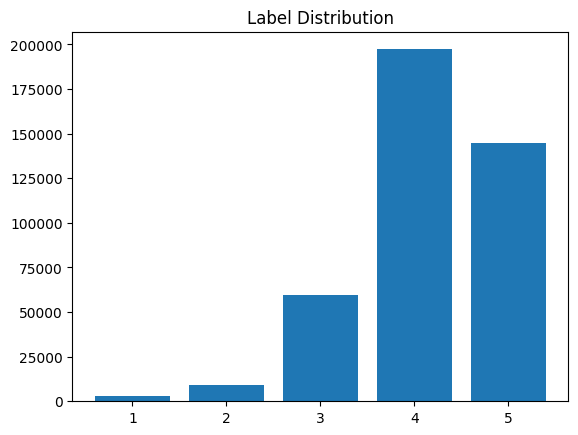

In [255]:
# Chart labels
rating_count = rating_count["own_id"].to_numpy()
ratings = range(1, 6)

# Show pie chart
plt.title("Label Distribution")
plt.bar(x=ratings, height=rating_count)
plt.show()

### Data Splitting

##### Creating user profile

In [256]:
# df_history = df_history.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features = pd.merge(df_history, df_inf_norm, left_on='inf_id', right_on='id', how='left')
df_inf_features = df_inf_features.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features.head()

,own_id,inf_id,combined_rating,id,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,1,1,0.785,1,0.735,0,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0
1,1,3,0.565,3,0.685,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
2,1,5,0.945,5,0.754,0,0,1,0,0,...,0,1,0,0,1,0,0,1,0,0
3,1,6,0.950,6,0.871,0,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0
4,1,7,0.800,7,0.830,0,0,1,1,1,...,0,1,0,0,1,0,0,1,0,0


In [257]:
OWNER_FEATURES = df_inf_norm.columns[1:]

# Copy influencer features combined with history data
df_own_norm = df_inf_features.copy()

# Multiply influencer feature with user rating
df_own_norm[OWNER_FEATURES] = df_own_norm[OWNER_FEATURES].mul(df_own_norm['combined_rating'], axis=0) 

# Drop unimportant features
df_own_norm = df_own_norm.drop(["inf_id", "id", "combined_rating"], axis=1)

# Average those with same owner id to make user profile
df_own_norm = df_own_norm.groupby('own_id').mean().reset_index()
df_own_norm.rename(columns={'own_id': 'id'}, inplace=True)

df_own_norm = df_own_norm.drop(['avg_rating'], axis=1)
df_own_norm.head()

,id,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,Category 3,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,1,0.000000,0.00000,0.821250,0.632500,0.632500,0.296875,0.000000,0.631875,0.000000,...,0.000000,0.821250,0.0,0.000000,0.821250,0.0,0.000000,0.821250,0.0,0.000000
1,2,0.036617,0.07491,0.753428,0.503832,0.428503,0.422844,0.001737,0.500150,0.114371,...,0.017784,0.742545,0.0,0.131033,0.686916,0.0,0.186662,0.749042,0.0,0.124536
2,3,0.000000,0.00000,0.828676,0.615441,0.560294,0.381029,0.000000,0.476618,0.000000,...,0.000000,0.793088,0.0,0.088824,0.776029,0.0,0.105882,0.881912,0.0,0.000000
3,4,0.000000,0.00000,0.825732,0.772927,0.713902,0.684268,0.019146,0.412439,0.038049,...,0.000000,0.825732,0.0,0.000000,0.807439,0.0,0.018293,0.825732,0.0,0.000000
4,5,0.000000,0.01736,0.782079,0.651404,0.541629,0.288876,0.006910,0.501236,0.168371,...,0.051292,0.767303,0.0,0.045225,0.767303,0.0,0.045225,0.795169,0.0,0.017360


##### Process feature and label

Influencer features

In [258]:
# Remove ID and labels
df_inf_features = df_inf_features.drop(["own_id", "inf_id", "id"], axis=1)

df_inf_features.head()

,combined_rating,avg_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,0.785,0.735,0,0,1,1,1,1,0,1,...,0,1,0,0,1,0,0,1,0,0
1,0.565,0.685,0,0,1,0,0,0,0,0,...,0,1,0,0,1,0,0,1,0,0
2,0.945,0.754,0,0,1,0,0,0,0,1,...,0,1,0,0,1,0,0,1,0,0
3,0.950,0.871,0,0,1,1,1,0,0,0,...,0,1,0,0,1,0,0,1,0,0
4,0.800,0.830,0,0,1,1,1,0,0,1,...,0,1,0,0,1,0,0,1,0,0


In [259]:
INFLUENCER_FEATURE_COUNT = len(df_inf_features.drop("combined_rating", axis=1).columns)

Owner features

In [260]:
# Join history and owner data by own_id
df_own_features = pd.merge(df_history.drop(["star_rating", "sentiment_rating"], axis=1), df_own_norm, left_on='own_id', right_on='id', how='left')

df_own_features.head()

,own_id,inf_id,combined_rating,id,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,1,1,0.785,1,0.0,0.0,0.82125,0.6325,0.6325,0.296875,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
1,1,3,0.565,1,0.0,0.0,0.82125,0.6325,0.6325,0.296875,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
2,1,5,0.945,1,0.0,0.0,0.82125,0.6325,0.6325,0.296875,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
3,1,6,0.950,1,0.0,0.0,0.82125,0.6325,0.6325,0.296875,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
4,1,7,0.800,1,0.0,0.0,0.82125,0.6325,0.6325,0.296875,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0


In [261]:
# Remove ID and labels
df_own_features = df_own_features.drop(["own_id", "inf_id", "id"], axis=1)

df_own_features.head()

,combined_rating,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,Category 3,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,0.785,0.0,0.0,0.82125,0.6325,0.6325,0.296875,0.0,0.631875,0.0,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
1,0.565,0.0,0.0,0.82125,0.6325,0.6325,0.296875,0.0,0.631875,0.0,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
2,0.945,0.0,0.0,0.82125,0.6325,0.6325,0.296875,0.0,0.631875,0.0,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
3,0.950,0.0,0.0,0.82125,0.6325,0.6325,0.296875,0.0,0.631875,0.0,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
4,0.800,0.0,0.0,0.82125,0.6325,0.6325,0.296875,0.0,0.631875,0.0,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0


In [262]:
OWNER_FEATURE_COUNT = len(df_own_features.drop("combined_rating", axis=1).columns)

Labels

In [263]:
# Get labels from history data
df_labels = df_history["combined_rating"]
df_labels.head()

0    0.785
1    0.565
2    0.945
3    0.950
4    0.800
Name: combined_rating, dtype: float64

In [264]:
df_inf_features = df_inf_features.drop(["combined_rating"], axis=1)
df_own_features = df_own_features.drop(["combined_rating"], axis=1)
df_own_features

,pricing_LOW,pricing_BELOW_AVG,pricing_AVG,pricing_ABOVE_AVG,pricing_HIGH,Category 1,Category 10,Category 2,Category 3,Category 4,...,Category 9,youtube_High,youtube_Low,youtube_Medium,tiktok_High,tiktok_Low,tiktok_Medium,insta_follower_High,insta_follower_Low,insta_follower_Medium
0,0.0,0.0,0.82125,0.63250,0.63250,0.296875,0.0,0.631875,0.0,0.00000,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
1,0.0,0.0,0.82125,0.63250,0.63250,0.296875,0.0,0.631875,0.0,0.00000,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
2,0.0,0.0,0.82125,0.63250,0.63250,0.296875,0.0,0.631875,0.0,0.00000,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
3,0.0,0.0,0.82125,0.63250,0.63250,0.296875,0.0,0.631875,0.0,0.00000,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
4,0.0,0.0,0.82125,0.63250,0.63250,0.296875,0.0,0.631875,0.0,0.00000,...,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0,0.82125,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413441,0.0,0.0,0.94875,0.94875,0.94875,0.948750,0.0,0.477500,0.0,0.94875,...,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0
413442,0.0,0.0,0.94875,0.94875,0.94875,0.948750,0.0,0.477500,0.0,0.94875,...,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0
413443,0.0,0.0,0.94875,0.94875,0.94875,0.948750,0.0,0.477500,0.0,0.94875,...,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0
413444,0.0,0.0,0.94875,0.94875,0.94875,0.948750,0.0,0.477500,0.0,0.94875,...,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0,0.94875,0.0,0.0


In [265]:
df_own_features.columns

Index(['pricing_LOW', 'pricing_BELOW_AVG', 'pricing_AVG', 'pricing_ABOVE_AVG',
       'pricing_HIGH', 'Category 1', 'Category 10', 'Category 2', 'Category 3',
       'Category 4', 'Category 5', 'Category 6', 'Category 7', 'Category 8',
       'Category 9', 'youtube_High', 'youtube_Low', 'youtube_Medium',
       'tiktok_High', 'tiktok_Low', 'tiktok_Medium', 'insta_follower_High',
       'insta_follower_Low', 'insta_follower_Medium'],
      dtype='object')

In [266]:
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import random

# Apply oversampling to each input type separately
smote = SMOTE()
df_features = pd.concat([df_inf_features, df_own_features], axis=1)
# df_features, star_ratings = smote.fit_resample(df_features, df_history['star_rating'].values)

In [267]:
# rating_count = np.unique(star_ratings, return_counts=True) 
# rating_count

In [268]:
# # Chart labels
# rating_count = rating_count[1]
# ratings = range(1, 6)

# # Show pie chart
# plt.title("Label Distribution")
# plt.bar(x=ratings, height=rating_count)
# plt.show()

In [269]:
# star_ratings = star_ratings / 5
# sentiment_ratings = star_ratings - 0.1 + 0.2 * random.random()
# df_labels = pd.Series((STAR_WEIGHT * star_ratings + SENTIMENT_WEIGHT * sentiment_ratings).clip(0, 1))

In [270]:
df_data = pd.concat([df_features, df_labels], axis=1)

In [271]:
df_inf_features = df_data.iloc[:, :INFLUENCER_FEATURE_COUNT]
df_own_features = df_data.iloc[:, INFLUENCER_FEATURE_COUNT:-1]
df_labels = df_data.iloc[:, -1]

##### Generate train, validation, and test dataset

In [272]:
# SHUFFLE_BUFFER = 1000

dataset = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features, "own_feature": df_own_features}, df_labels))
# dataset = dataset.shuffle(SHUFFLE_BUFFER) 

dataset.element_spec

({'inf_feature': TensorSpec(shape=(25,), dtype=tf.float64, name=None),
  'own_feature': TensorSpec(shape=(24,), dtype=tf.float64, name=None)},
 TensorSpec(shape=(), dtype=tf.float64, name=None))

In [273]:
# Generate training, validation, and testing data
DATASET_SIZE = dataset.cardinality().numpy()
TRAIN_SIZE = int(DATASET_SIZE * 0.95)
VAL_SIZE = int(DATASET_SIZE * 0.025)
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE - VAL_SIZE

train_dataset = dataset.take(TRAIN_SIZE)
val_dataset = dataset.skip(TRAIN_SIZE).take(VAL_SIZE)
test_dataset = dataset.skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

print(f"Training dataset has {train_dataset.cardinality().numpy()} data")
print(f"Validation dataset has {val_dataset.cardinality().numpy()} data")
print(f"Testing dataset has {test_dataset.cardinality().numpy()} data")

Training dataset has 392773 data
Validation dataset has 10336 data
Testing dataset has 10337 data


In [274]:
# Batching
REPEAT = 2

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

In [275]:
train_dataset = train_dataset.cache()
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

##### Check Distribution

In [276]:
def get_label(dataset):
    labels = np.array([])
    for batch in dataset:
        labels = np.concatenate([labels, batch[1].numpy()])

    return labels

In [277]:
bin = [0, 0.2, 0.4, 0.6, 0.8, 1]
bucket = np.digitize(get_label(train_dataset), bin)
np.unique(bucket, return_counts=True)

(array([1, 2, 3, 4, 5, 6], dtype=int64),
 array([  1876,   6305,  39189, 152654, 159829,  32920], dtype=int64))

In [278]:
bin = [0, 0.2, 0.4, 0.6, 0.8, 1]
bucket = np.digitize(get_label(val_dataset), bin)
np.unique(bucket, return_counts=True)

(array([1, 2, 3, 4, 5, 6], dtype=int64),
 array([  32,  136,  953, 4031, 4398,  786], dtype=int64))

In [279]:
bin = [0, 0.2, 0.4, 0.6, 0.8, 1]
bucket = np.digitize(get_label(test_dataset), bin)
np.unique(bucket, return_counts=True)

(array([1, 2, 3, 4, 5, 6], dtype=int64),
 array([  30,  103,  756, 4025, 4503,  920], dtype=int64))

# Error Analysis

## Prepare

In [350]:
import os

MODEL = "recommender-smote-try-simple-I"

In [351]:
# with open(os.path.join("model/summary/", MODEL + ".txt")) as f:
#     print("".join(f.readlines()))

In [352]:
import tensorflow as tf

print(tf.__version__)

export_path = f"./model/savedmodel/{MODEL}/"
model = tf.saved_model.load(export_path)
infer = model.signatures["serving_default"]
print(infer.inputs, "\n\n", infer.outputs)

2.12.0
[<tf.Tensor 'inf_feature:0' shape=(None, 25) dtype=float32>, <tf.Tensor 'own_feature:0' shape=(None, 24) dtype=float32>, <tf.Tensor 'unknown:0' shape=() dtype=resource>, <tf.Tensor 'unknown_0:0' shape=() dtype=resource>, <tf.Tensor 'unknown_1:0' shape=() dtype=resource>, <tf.Tensor 'unknown_2:0' shape=() dtype=resource>, <tf.Tensor 'unknown_3:0' shape=() dtype=resource>, <tf.Tensor 'unknown_4:0' shape=() dtype=resource>, <tf.Tensor 'unknown_5:0' shape=() dtype=resource>, <tf.Tensor 'unknown_6:0' shape=() dtype=resource>] 

 [<tf.Tensor 'Identity:0' shape=(None, 1) dtype=float32>]


Helpers

In [366]:
def convert_tensor(array):
    return tf.expand_dims(tf.convert_to_tensor(array, tf.float32), 0)

def convert_dataset_to_numpy(dataset):
    inputs = []
    labels = np.array([])
    for batch in dataset:
        # batch_input = []
        # for data in batch[0]['inf_feature']:
        #     batch_input.append({'inputs_0': data})
        
        # for i, data in enumerate(batch[0]['own_feature']):
        #     batch_input[i]['inputs_1'] = data

        # inputs.append(batch_input)
        inf_feature = batch[0]['inf_feature'].numpy()
        own_feature = batch[0]['own_feature'].numpy()

        
        # print(inf_feature, own_feature)
        inputs += [{"inf_feature": convert_tensor(a_val), "own_feature": convert_tensor(b_val)} for a_val, b_val in zip(inf_feature, own_feature)]

        labels = np.concatenate([labels, batch[1].numpy()])

    return inputs, labels

def get_comparation_from_dataset(dataset, infer):
    inputs, labels = convert_dataset_to_numpy(dataset)

    # print(inputs)
    
    predict = []
    print(inputs)
    for data in inputs:
        predict.append(infer(**data))

    predict = list(pred['dot_2'].numpy()[0] for pred in predict)

    compare = pd.concat([pd.DataFrame(predict, columns=["predicted"]), 
                     pd.DataFrame(labels, columns=["real"])], axis=1)

    compare["error"] = abs(compare["predicted"] - compare["real"])

    return compare

def get_rank_quality(real_rank, predicted_rank):
    from scipy.stats import kendalltau

    corr_score = []
    count = []
    for id, rank in real_rank.iteritems():
        # print(list(rank)[:len(predicted_rank[id])], list(predicted_rank[id]))
        correlation, _ = kendalltau(list(rank), list(predicted_rank[id]))
        corr_score.append(correlation)
        count.append(len(list(rank)))

    df_corr = pd.concat([real_rank, predicted_rank, pd.Series(corr_score, index=real_rank.index), pd.Series(count, index=real_rank.index)], axis=1)
    return df_corr

def ap_at_k(real_rank, predicted_rank, k):
    ap_score = []
    for id, rank in real_rank.iteritems():
        pred = predicted_rank[id]
        relevancy = [int(el in rank[:k]) for el in pred[:k]]
        ap_score.append(sum(elem / (index + 1) for index, elem in enumerate(relevancy)) / len(relevancy))
    
    return np.array(ap_score)

get_comparation_from_dataset(dataset.take(32).batch(32), infer)

[{'inf_feature': <tf.Tensor: shape=(1, 25), dtype=float32, numpy=
array([[0.735, 0.   , 0.   , 1.   , 1.   , 1.   , 1.   , 0.   , 1.   ,
        0.   , 0.   , 1.   , 0.   , 0.   , 1.   , 0.   , 1.   , 0.   ,
        0.   , 1.   , 0.   , 0.   , 1.   , 0.   , 0.   ]], dtype=float32)>, 'own_feature': <tf.Tensor: shape=(1, 24), dtype=float32, numpy=
array([[0.      , 0.      , 0.82125 , 0.6325  , 0.6325  , 0.296875,
        0.      , 0.631875, 0.      , 0.      , 0.7025  , 0.      ,
        0.11875 , 0.6075  , 0.      , 0.82125 , 0.      , 0.      ,
        0.82125 , 0.      , 0.      , 0.82125 , 0.      , 0.      ]],
      dtype=float32)>}, {'inf_feature': <tf.Tensor: shape=(1, 25), dtype=float32, numpy=
array([[0.685, 0.   , 0.   , 1.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
        0.   , 0.   , 1.   , 0.   , 0.   , 1.   , 0.   , 1.   , 0.   ,
        0.   , 1.   , 0.   , 0.   , 1.   , 0.   , 0.   ]], dtype=float32)>, 'own_feature': <tf.Tensor: shape=(1, 24), dtype=float32, numpy=
array([

,predicted,real,error
0,0.840083,0.785,0.055083
1,0.759405,0.565,0.194405
2,0.895242,0.945,0.049758
3,0.993614,0.950,0.043614
4,0.983111,0.800,0.183111
5,0.993329,0.935,0.058329
6,0.989850,0.825,0.164850
7,0.784350,0.765,0.019350
8,0.996467,1.000,0.003533
9,0.929247,0.755,0.174247


## Compare

In [365]:
# compare_train = get_comparation_from_dataset(train_dataset, infer)
# compare_val = get_comparation_from_dataset(val_dataset, infer)
compare_test = get_comparation_from_dataset(dataset.take(100000).batch(32), infer)

KeyboardInterrupt: 

In [355]:
compare_test

,predicted,real,error
0,0.840083,0.785,0.055083
1,0.759405,0.565,0.194405
2,0.895242,0.945,0.049758
3,0.993614,0.950,0.043614
4,0.983111,0.800,0.183111
...,...,...,...
99995,0.572857,0.795,0.222143
99996,0.708075,0.560,0.148075
99997,0.764492,0.945,0.180508
99998,0.742684,0.975,0.232316


In [363]:
compare_test[compare_test['error'] <= 0.2]

,predicted,real,error
0,0.840083,0.785,0.055083
1,0.759405,0.565,0.194405
2,0.895242,0.945,0.049758
3,0.993614,0.950,0.043614
4,0.983111,0.800,0.183111
...,...,...,...
99991,0.655098,0.725,0.069902
99993,0.635018,0.735,0.099982
99996,0.708075,0.560,0.148075
99997,0.764492,0.945,0.180508


In [357]:
compare_test['error'].mean()

0.10774274774895312

In [358]:
# Get owner and influencer data
# pos_owner_inf = df_history.iloc[df_inf_features_pos.index]
# neg_owner_inf = df_history.iloc[df_inf_features_neg.index]
combined_owner_inf = df_history[:100000].drop('combined_rating', axis=1)
combined_owner_inf

,own_id,inf_id,star_rating,sentiment_rating
0,1,1,4,0.77
1,1,3,3,0.53
2,1,5,5,0.89
3,1,6,5,0.90
4,1,7,4,0.80
...,...,...,...,...
99995,1173,526,4,0.79
99996,1173,181,3,0.52
99997,1173,1416,5,0.89
99998,1173,383,5,0.95


In [359]:
test = pd.concat([combined_owner_inf.reset_index(), compare_test.reset_index()], axis=1)
test = test.drop('index', axis=1)
test

,own_id,inf_id,star_rating,sentiment_rating,predicted,real,error
0,1,1,4,0.77,0.840083,0.785,0.055083
1,1,3,3,0.53,0.759405,0.565,0.194405
2,1,5,5,0.89,0.895242,0.945,0.049758
3,1,6,5,0.90,0.993614,0.950,0.043614
4,1,7,4,0.80,0.983111,0.800,0.183111
...,...,...,...,...,...,...,...
99995,1173,526,4,0.79,0.572857,0.795,0.222143
99996,1173,181,3,0.52,0.708075,0.560,0.148075
99997,1173,1416,5,0.89,0.764492,0.945,0.180508
99998,1173,383,5,0.95,0.742684,0.975,0.232316


In [360]:
real_rank = test.groupby('own_id').apply(lambda x: x.sort_values(by='real', ascending=False)['inf_id'].tolist())
predicted_rank = test.groupby('own_id').apply(lambda x: x.sort_values(by='predicted', ascending=False)['inf_id'].tolist())

In [361]:
ap_at_k(real_rank, predicted_rank, 10).mean()

C:\Users\MAS GAMING\AppData\Local\Temp\ipykernel_9064\688595295.py:61: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for id, rank in real_rank.iteritems():


0.2147813912214012

In [362]:
stopper

NameError: name 'stopper' is not defined

In [ ]:
test = pd.merge(test, df_influencer, how='left', left_on ='inf_id', right_on='id')
test = pd.merge(test, df_own_norm, how='left', left_on='own_id', right_on='id')

In [ ]:
test.to_csv("test.csv")
df_corr.to_csv("correlations.csv")

In [ ]:
# compare_val['error'].mean()

In [ ]:
# compare_test['error'].mean()

In [ ]:
Stopper

# Skip this

## Data Extraction

### Load data from CSV

Not using user data for a while

Data is generated randomly using Excel

In [ ]:
DATA_DIR = os.path.join("../data/synt_data_with_average_rating/")
INFLUENCER_FILE = os.path.join(DATA_DIR, "data_content_influencer_categ.csv")
OWNER_FILE = os.path.join(DATA_DIR, "data_content_owner_categ.csv")
HISTORY_FILE = os.path.join(DATA_DIR, "historical_data.csv")

df_influencer = pd.read_csv(INFLUENCER_FILE)
# df_owner = pd.read_csv(OWNER_FILE)
df_history = pd.read_csv(HISTORY_FILE)

### Data Exploration

In [ ]:
df_influencer.head(5)

In [ ]:
df_influencer.info()

In [ ]:
df_influencer.describe()

In [ ]:
df_history.head(5)

In [ ]:
df_history.info()

In [ ]:
df_history.describe()

## Data Transformation

### Data cleaning

#### Missing value

In [ ]:
df_influencer.isnull().sum()

In [ ]:
df_history.isnull().sum()

No missing value

#### Irrelevant Data / Invalid Data

Check if all history has valid influencer and owner ID

In [ ]:
df_history["inf_id"].isin(df_influencer["id"]).all()

All history data has valid influencer and owner ID

### Data Normalization

Normalize influencer data: Scale follower count and One-hot categories

In [ ]:
follower_scaler = MinMaxScaler()

df_inf_norm = df_influencer.copy()
df_inf_norm[["insta_follower", "tiktok", "youtube"]] = follower_scaler.fit_transform(df_inf_norm[["insta_follower", "tiktok", "youtube"]])

one_hot_price = df_inf_norm['price_category'].str.get_dummies()
df_inf_norm = pd.concat([df_inf_norm, one_hot_price], axis=1)
df_inf_norm = df_inf_norm.drop('price_category', axis=1)

one_hot_categories = df_inf_norm['categories'].str.get_dummies(sep=',')
df_inf_norm = pd.concat([df_inf_norm, one_hot_categories], axis=1)
df_inf_norm = df_inf_norm.drop('categories', axis=1)

df_inf_norm.head()

Remove some category

In [ ]:
categories_count = df_inf_norm[df_inf_norm.columns[8:]].sum().sort_values(ascending=False)

column_name = list(categories_count.nlargest(10).index)
column_name
# plt.plot

Combine star and sentiment rating

In [ ]:
STAR_WEIGHT = 0.6
SENTIMENT_WEIGHT = 0.4

df_history["combined_rating"] = STAR_WEIGHT * df_history["star_rating"] / 5 + SENTIMENT_WEIGHT * df_history["sentiment_rating"]
df_history

In [ ]:
rating_count = df_history.groupby("star_rating").count()
rating_count

In [ ]:
# Chart labels
rating_count = rating_count["own_id"].to_numpy()
ratings = range(1, 6)

# Show pie chart
plt.title("Label Distribution")
plt.bar(x=ratings, height=rating_count)
plt.show()

### Data Splitting

##### Creating user profile

In [ ]:
df_history = df_history.drop(["star_rating", "sentiment_rating"], axis=1)
df_inf_features = pd.merge(df_history, df_inf_norm, left_on='inf_id', right_on='id', how='left')
df_inf_features.head()

In [ ]:
OWNER_FEATURES = df_inf_norm.columns[1:]

# Copy influencer features combined with history data
df_own_norm = df_inf_features.copy()

# Multiply influencer feature with user rating
df_own_norm[OWNER_FEATURES] = df_own_norm[OWNER_FEATURES].mul(df_own_norm['combined_rating'], axis=0) 

# Drop unimportant features
df_own_norm = df_own_norm.drop(["inf_id", "id", "combined_rating"], axis=1)

# Average those with same owner id to make user profile
df_own_norm = df_own_norm.groupby('own_id').mean().reset_index()
df_own_norm.rename(columns={'own_id': 'id'}, inplace=True)

df_own_norm.head()

##### Process feature and label

Influencer features

In [ ]:
# Remove ID and labels
df_inf_features = df_inf_features.drop(["own_id", "inf_id", "id"], axis=1)

df_inf_features.head()

In [ ]:
df_inf_features_pos = df_inf_features[df_inf_features["combined_rating"] > 0.6].drop(["combined_rating"], axis=1)
df_inf_features_neg = df_inf_features[df_inf_features["combined_rating"] <= 0.6].drop(["combined_rating"], axis=1)

df_inf_features_pos

In [ ]:
INFLUENCER_FEATURE_COUNT = len(df_inf_features.drop("combined_rating", axis=1).columns)

Owner features

In [ ]:
# Join history and owner data by own_id
df_own_features = pd.merge(df_history, df_own_norm, left_on='own_id', right_on='id', how='left')

df_own_features.head()

In [ ]:
# Remove ID and labels
df_own_features = df_own_features.drop(["own_id", "inf_id", "id"], axis=1)

df_own_features.head()

In [ ]:
df_own_features_pos = df_own_features[df_own_features["combined_rating"] > 0.6].drop(["combined_rating"], axis=1)
df_own_features_neg = df_own_features[df_own_features["combined_rating"] <= 0.6].drop(["combined_rating"], axis=1)

df_own_features_pos

In [ ]:
OWNER_FEATURE_COUNT = len(df_own_features.drop("combined_rating", axis=1).columns)

Labels

In [ ]:
# Get labels from history data
df_labels = df_history["combined_rating"]
df_labels.head()

In [ ]:
df_labels_pos = df_labels[df_labels > 0.6]
df_labels_neg = df_labels[df_labels <= 0.6]

df_labels_pos

##### Generate train, validation, and test dataset

In [ ]:
SHUFFLE_BUFFER = 1000

dataset = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features, "own_feature": df_own_features}, df_labels))
dataset = dataset.shuffle(SHUFFLE_BUFFER) 

dataset.element_spec

In [ ]:
# Generate training, validation, and testing data
DATASET_SIZE = dataset.cardinality().numpy()
TRAIN_SIZE = int(DATASET_SIZE * 0.9)
VAL_SIZE = int(DATASET_SIZE * 0.05)
TEST_SIZE = DATASET_SIZE - TRAIN_SIZE - VAL_SIZE

train_dataset = dataset.take(TRAIN_SIZE)
val_dataset = dataset.skip(TRAIN_SIZE).take(VAL_SIZE)
test_dataset = dataset.skip(TRAIN_SIZE + VAL_SIZE).take(TEST_SIZE)

print(f"Training dataset has {train_dataset.cardinality().numpy()} data")
print(f"Validation dataset has {val_dataset.cardinality().numpy()} data")
print(f"Testing dataset has {test_dataset.cardinality().numpy()} data")

In [ ]:
# Batching
REPEAT = 2

train_dataset = train_dataset.batch(BATCH_SIZE).repeat(REPEAT)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

##### Generate train, validation, and test dataset (positive and negative)

In [ ]:
SHUFFLE_BUFFER = 1000

dataset_pos = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features_pos, "own_feature": df_own_features_pos}, df_labels_pos))
# dataset_pos = dataset_pos.shuffle(SHUFFLE_BUFFER) 
dataset_neg = tf.data.Dataset.from_tensor_slices(({"inf_feature": df_inf_features_neg, "own_feature": df_own_features_neg}, df_labels_neg))
# dataset_neg = dataset_neg.shuffle(SHUFFLE_BUFFER) 

print("Positive data:", dataset_pos.element_spec)
print("Count positive data:", dataset_pos.cardinality().numpy())

print("\nNegative data:", dataset_neg.element_spec)
print("Count negative data:", dataset_neg.cardinality().numpy())

In [ ]:
# Generate training, validation, and testing data
POSITIVE_SIZE = dataset_pos.cardinality().numpy()
TRAIN_POS_SIZE = int(POSITIVE_SIZE * 0.9)
VAL_POS_SIZE = int(POSITIVE_SIZE * 0.05)
TEST_POS_SIZE = POSITIVE_SIZE - TRAIN_POS_SIZE - VAL_POS_SIZE

train_dataset_pos = dataset_pos.take(TRAIN_POS_SIZE)
val_dataset_pos = dataset_pos.skip(TRAIN_POS_SIZE).take(VAL_POS_SIZE)
test_dataset_pos = dataset_pos.skip(TRAIN_POS_SIZE + VAL_POS_SIZE).take(TEST_POS_SIZE)

print(f"Positive training dataset has {train_dataset_pos.cardinality().numpy()} data")
print(f"Positive validation dataset has {val_dataset_pos.cardinality().numpy()} data")
print(f"Positive testing dataset has {test_dataset_pos.cardinality().numpy()} data")

In [ ]:
# Generate training, validation, and testing data
NEGATIVE_SIZE = dataset_neg.cardinality().numpy()
TRAIN_NEG_SIZE = int(NEGATIVE_SIZE * 0.5)
VAL_NEG_SIZE = int(NEGATIVE_SIZE * 0.25)
TEST_NEG_SIZE = NEGATIVE_SIZE - TRAIN_NEG_SIZE - VAL_NEG_SIZE

train_dataset_neg = dataset_neg.take(TRAIN_NEG_SIZE)
val_dataset_neg = dataset_neg.skip(TRAIN_NEG_SIZE).take(VAL_NEG_SIZE)
test_dataset_neg = dataset_neg.skip(TRAIN_NEG_SIZE + VAL_NEG_SIZE).take(TEST_NEG_SIZE)

print(f"Negative training dataset has {train_dataset_neg.cardinality().numpy()} data")
print(f"Negative validation dataset has {val_dataset_neg.cardinality().numpy()} data")
print(f"Negative testing dataset has {test_dataset_neg.cardinality().numpy()} data")

In [ ]:
train_dataset = train_dataset_pos.concatenate(train_dataset_neg)
val_dataset = val_dataset_pos.concatenate(val_dataset_neg)
test_dataset = test_dataset_pos.concatenate(test_dataset_neg)

print(f"Training dataset has {train_dataset.cardinality().numpy()} data")
print(f"Validation dataset has {val_dataset.cardinality().numpy()} data")
print(f"Testing dataset has {test_dataset.cardinality().numpy()} data")

In [ ]:
# Batching
REPEAT = 2

train_dataset = train_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)